# Project 5: Gun Violence

In [225]:
import calendar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression # , Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import LogisticRegression

## Data Cleaning and EDA

In [2]:
gun = pd.read_csv('../datasets/gun_violence_2013_2018.csv')
gun.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [3]:
gun.shape

(239677, 29)

In [4]:
gun.sort_values(by=['n_killed'], ascending=False).head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
130448,577157,2016-06-12,Florida,Orlando,1912 S Orange Avenue,50,53,http://www.gunviolencearchive.org/incident/577157,https://www.reuters.com/article/us-orlando-sho...,False,...,0::34||1::23||2::20||3::22||4::36||5::22||6::2...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male||5...,0::Edward Sotomayor Jr||1::Stanley Almodovar I...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://www.cityoforlando.net/police/mass-shoot...,47.0,12.0
217151,980577,2017-11-05,Texas,Sutherland Springs,216 4th St,27,20,http://www.gunviolencearchive.org/incident/980577,http://abc7.com/full-list-of-texas-church-shoo...,False,...,0::14||1::7||2::5||3::30||4::58||5::60||6::36|...,0::Teen 12-17||1::Child 0-11||2::Child 0-11||3...,0::Female||1::Female||2::Female||3::Female||4:...,0::Annabelle Renee Pomeroy||1::Emily Garcia||2...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://13wham.com/news/nation-world/multiple-i...,44.0,21.0
232745,1049217,2018-02-14,Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17,http://www.gunviolencearchive.org/incident/104...,http://www.orlandosentinel.com/news/fl-florida...,False,...,0::35||1::14||2::17||3::37||4::14||5::15||6::4...,0::Adult 18+||1::Teen 12-17||2::Teen 12-17||3:...,0::Male||1::Male||2::Male||3::Male||4::Female|...,0::Scott Beigel||1::Martin Duque Anguiano||2::...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://cbs12.com/news/local/shooting-at-marjor...,96.0,29.0
101531,456893,2015-12-02,California,San Bernardino,1365 South Waterman Avenue,16,19,http://www.gunviolencearchive.org/incident/456893,http://www.latimes.com/local/lanow/la-me-ln-sa...,False,...,0::42||1::58||2::52||3::37||4::40||5::27||6::4...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Male||5::Female|...,0::Larry Daniel Kaufman||1::Damian Meins||2::N...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://www.sbsun.com/general-news/20151202/14-...,40.0,23.0
194,480366,2013-09-16,District of Columbia,Washington Navy Yard,1336 Isaac Hull Ave,11,3,http://www.gunviolencearchive.org/incident/480366,https://www.washingtonpost.com/local/police-se...,False,...,0::59||1::53||2::51||3::53||4::62||5::73||6::5...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Female||4::Femal...,0::Michael Arnold||1::Martin Bodrog||2::Arthur...,15::Co-worker,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://www.nbcwashington.com/news/local/Confir...,NaN,NaN


In [5]:
gun.isna().mean()

incident_id                    0.000000
date                           0.000000
state                          0.000000
city_or_county                 0.000000
address                        0.068830
n_killed                       0.000000
n_injured                      0.000000
incident_url                   0.000000
source_url                     0.001953
incident_url_fields_missing    0.000000
congressional_district         0.049834
gun_stolen                     0.415134
gun_type                       0.414938
incident_characteristics       0.001360
latitude                       0.033057
location_description           0.824393
longitude                      0.033057
n_guns_involved                0.414938
notes                          0.338026
participant_age                0.385093
participant_age_group          0.175732
participant_gender             0.151713
participant_name               0.510074
participant_relationship       0.934186
participant_status             0.115263


In [6]:
gun.state.value_counts()

state
Illinois                17556
California              16306
Florida                 15029
Texas                   13577
Ohio                    10244
New York                 9712
Pennsylvania             8929
Georgia                  8925
North Carolina           8739
Louisiana                8103
Tennessee                7626
South Carolina           6939
Missouri                 6631
Michigan                 6136
Massachusetts            5981
Virginia                 5949
Indiana                  5852
Maryland                 5798
Alabama                  5471
New Jersey               5387
Wisconsin                4787
Kentucky                 4157
Mississippi              3599
Oklahoma                 3455
Washington               3434
Colorado                 3201
District of Columbia     3195
Connecticut              3067
Arkansas                 2842
Iowa                     2517
Minnesota                2408
Arizona                  2328
Oregon                   2286
Kans

In [7]:
gun.n_killed.value_counts()

n_killed
0     185835
1      48436
2       4604
3        595
4        139
5         41
6         11
8          5
9          3
7          2
11         1
10         1
16         1
50         1
27         1
17         1
Name: count, dtype: int64

In [8]:
gun.n_injured.value_counts()

n_injured
0     142487
1      81986
2      11484
3       2513
4        760
5        241
6         91
7         51
8         19
9         12
10         6
12         5
11         4
19         3
14         3
13         2
16         2
15         2
17         2
18         1
53         1
25         1
20         1
Name: count, dtype: int64

In [9]:
gun['casualties'] = gun.n_injured + gun.n_killed
gun.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,casualties
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,4
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,4
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,4
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,4
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,4


In [10]:
gun.casualties.value_counts()

casualties
1      116228
0       97287
2       19794
3        4266
4        1340
5         433
6         136
7          88
8          40
9          20
12         10
10          8
18          3
13          3
15          3
11          3
19          2
14          2
17          2
21          1
16          1
47          1
25          1
20          1
103         1
35          1
27          1
34          1
Name: count, dtype: int64

In [11]:
gun.date = pd.to_datetime(gun.date)

In [263]:
gun['day_of_week'] = gun.date.dt.day_of_week
gun['month'] = gun.date.dt.month
gun[['day_of_week', 'month']]

,day_of_week,month
0,1,1
1,1,1
2,1,1
3,5,1
4,0,1
...,...,...
239672,5,3
239673,5,3
239674,5,3
239675,5,3


In [13]:
gun['year'] = gun.date.dt.year
gun.year

0         2013
1         2013
2         2013
3         2013
4         2013
          ... 
239672    2018
239673    2018
239674    2018
239675    2018
239676    2018
Name: year, Length: 239677, dtype: int32

In [14]:
gun[['year']].value_counts().sort_values()

year
2013      278
2018    13802
2014    51854
2015    53579
2016    58763
2017    61401
Name: count, dtype: int64

In [15]:
gun.dtypes

incident_id                             int64
date                           datetime64[ns]
state                                  object
city_or_county                         object
address                                object
n_killed                                int64
n_injured                               int64
incident_url                           object
source_url                             object
incident_url_fields_missing              bool
congressional_district                float64
gun_stolen                             object
gun_type                               object
incident_characteristics               object
latitude                              float64
location_description                   object
longitude                             float64
n_guns_involved                       float64
notes                                  object
participant_age                        object
participant_age_group                  object
participant_gender                

In [20]:
gun[['state', 'n_killed', ]].groupby(by=['state']).mean()

,n_killed
state,
Alabama,0.343630
Alaska,0.197924
Arizona,0.469931
Arkansas,0.271992
California,0.341101
Colorado,0.248672
Connecticut,0.111184
Delaware,0.128783
District of Columbia,0.143662


### Unpack List and Dict columns

In [23]:
%%time
def get_part(index):
    suspect_part = None
    try:
        for part in parts[index].split('||'):
            part = part.split('::')
            if part[0] == suspect_id:
                suspect_part = part[1]
        # print(suspect_age_group)
    except AttributeError:
        pass
    return suspect_part


items = []

for i, parts in gun.iterrows():
    suspect_id = None
    suspect_age = None
    suspect_age_group = None
    suspect_gender = None
    suspect_name = None
    suspect_name_first = None
    suspect_name_last = None
    suspect_status = None

    # print(i)
    
    # Get suspect id
    try:
        for part in parts[25].split('||'):
            part = part.split('::')
            if part[1] == 'Subject-Suspect':
                suspect_id = part[0]
        # print(suspect_id)
    except (AttributeError, IndexError):
        pass

    # Make sure suspect_id isn't nan. Note that nan is unequivalent to itself
    if suspect_id == suspect_id:
        suspect_age = get_part(19)
        suspect_age_group = get_part(20)
        suspect_gender = get_part(21)
        suspect_status = get_part(24)
        
        # Get perpetrator name, first, and last
        try:
            for part in parts[22].split('||'):
                part = part.split('::')
                if part[0] == suspect_id:
                    suspect_name = part[1]
                    name_parts = suspect_name.split(' ')
                    suspect_name_first = name_parts[0]
                    suspect_name_last = name_parts[1]
            # print(suspect_name)
        except (AttributeError, IndexError):
            pass

    item = {
        'suspect_age': suspect_age,
        'suspect_age_group': suspect_age_group,
        'suspect_gender': suspect_gender,
        'suspect_name': suspect_name,
        'suspect_first_name': suspect_name_first,
        'suspect_last_name': suspect_name_last,
        'suspect_status': suspect_status
    }
    items.append(item)

<timed exec>:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


CPU times: total: 17.1 s
Wall time: 21.4 s


In [24]:
temp = pd.DataFrame(items)
temp.head()

,suspect_age,suspect_age_group,suspect_gender,suspect_name,suspect_first_name,suspect_last_name,suspect_status
0,None,Adult 18+,Female,None,None,None,Injured
1,None,None,None,None,None,None,None
2,31,Adult 18+,Male,Desmen Noble,Desmen,Noble,"Unharmed, Arrested"
3,33,Adult 18+,Male,Sonny Archuleta,Sonny,Archuleta,Killed
4,47,Adult 18+,Female,Sandra Palmer,Sandra,Palmer,Killed


In [25]:
temp.shape

(239677, 7)

In [26]:
gun = pd.concat([gun, temp], axis=1)
gun.shape

(239677, 39)

In [27]:
gun.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,casualties,day_of_week,year,suspect_age,suspect_age_group,suspect_gender,suspect_name,suspect_first_name,suspect_last_name,suspect_status
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,4,1,2013,None,Adult 18+,Female,None,None,None,Injured
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,4,1,2013,None,None,None,None,None,None,None
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,4,1,2013,31,Adult 18+,Male,Desmen Noble,Desmen,Noble,"Unharmed, Arrested"
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,4,5,2013,33,Adult 18+,Male,Sonny Archuleta,Sonny,Archuleta,Killed
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,4,0,2013,47,Adult 18+,Female,Sandra Palmer,Sandra,Palmer,Killed


In [28]:
items = []

for i, parts in gun.iterrows():
    stolen = 0
    not_stolen = 0
    unknown_if_stolen = 0
    try:
        for part in parts[11].split('||'):
            part = part.split('::')
            label = part[1].lower()
            if label == 'stolen':
                stolen += 1
            elif label == 'not-stolen':
                not_stolen += 1
            else:
                unknown_if_stolen += 1
    except (AttributeError, IndexError):
        pass

    item = {
        'stolen_count': stolen,
        'not_stolen_count': not_stolen,
        'unknown_if_stolen_count': unknown_if_stolen
    }
    items.append(item)

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\3711415166.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[11].split('||'):


In [29]:
temp = pd.DataFrame(items)
temp.stolen_count.value_counts()

stolen_count
0     232327
1       5315
2        873
3        335
4        186
5        103
6         78
7         60
9         36
10        34
8         34
12        28
14        24
15        22
11        20
13        17
17        17
20        14
16        12
19        11
25        10
30        10
18        10
24         9
22         9
26         8
27         6
40         6
23         6
21         5
50         4
39         4
31         4
29         4
28         4
32         3
35         3
43         3
41         2
34         2
55         2
33         2
38         2
44         2
47         2
45         2
60         1
42         1
36         1
70         1
48         1
46         1
37         1
Name: count, dtype: int64

In [30]:
gun = pd.concat([gun, temp], axis=1)
gun.shape

(239677, 42)

In [32]:
all_gun_types = set()
for i, parts in gun.iterrows():
    
    try:
        for part in parts[12].split('||'):
            part = part.split('::')
            label = part[1]
            all_gun_types.add(label)
    except (AttributeError, IndexError):
        pass

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\700465017.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[12].split('||'):


In [33]:
gun_types_cleaned = [x.replace(' ', '_').replace('[', '').replace(']', '') for x in all_gun_types]
gun_types_cleaned

['45_Auto',
 '10mm',
 '12_gauge',
 '410_gauge',
 'Shotgun',
 '30-30_Win',
 '380_Auto',
 '32_Auto',
 '9mm',
 '22_LR',
 '38_Spl',
 '44_Mag',
 'Unknown',
 'Handgun',
 '28_gauge',
 'Other',
 'Rifle',
 '357_Mag',
 '7.62_AK-47',
 '30-06_Spr',
 '16_gauge',
 '300_Win',
 '223_Rem_AR-15',
 '308_Win',
 '25_Auto',
 '20_gauge',
 '40_SW']

In [34]:
def create_gun_dict():
    gun_types = {}
    for item in all_gun_types:
        gun_types[item] = 0
    return gun_types

create_gun_dict()

{'45 Auto': 0,
 '10mm': 0,
 '12 gauge': 0,
 '410 gauge': 0,
 'Shotgun': 0,
 '30-30 Win': 0,
 '380 Auto': 0,
 '32 Auto': 0,
 '9mm': 0,
 '22 LR': 0,
 '38 Spl': 0,
 '44 Mag': 0,
 'Unknown': 0,
 'Handgun': 0,
 '28 gauge': 0,
 'Other': 0,
 'Rifle': 0,
 '357 Mag': 0,
 '7.62 [AK-47]': 0,
 '30-06 Spr': 0,
 '16 gauge': 0,
 '300 Win': 0,
 '223 Rem [AR-15]': 0,
 '308 Win': 0,
 '25 Auto': 0,
 '20 gauge': 0,
 '40 SW': 0}

In [35]:
items = []

for i, parts in gun.iterrows():
    gun_type_counts = create_gun_dict()
    try:
        for part in parts[12].split('||'):
            part = part.split('::')
            gun_type = part[1]
            gun_type_counts[gun_type] += 1 
    except (AttributeError, IndexError):
        pass

    items.append(gun_type_counts)

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\2813834031.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[12].split('||'):


In [36]:
temp = pd.DataFrame(items)
temp.columns = gun_types_cleaned
temp.head(20)

,45_Auto,10mm,12_gauge,410_gauge,Shotgun,30-30_Win,380_Auto,32_Auto,9mm,22_LR,...,357_Mag,7.62_AK-47,30-06_Spr,16_gauge,300_Win,223_Rem_AR-15,308_Win,25_Auto,20_gauge,40_SW
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
gun = pd.concat([gun, temp], axis=1)
gun.shape

(239677, 69)

In [38]:
all_gun_types = set()
for i, parts in gun.iterrows():
    
    try:
        for part in parts[12].split('||'):
            part = part.split('::')
            label = part[1]
            all_gun_types.add(label)
    except (AttributeError, IndexError):
        pass

gun_types_cleaned = [x.replace(' ', '_').replace('[', '').replace(']', '') for x in all_gun_types]

def create_gun_dict():
    gun_types = {}
    for item in all_gun_types:
        gun_types[item] = 0
    return gun_types


items = []

for i, parts in gun.iterrows():
    gun_type_counts = create_gun_dict()
    try:
        for part in parts[12].split('||'):
            part = part.split('::')
            gun_type = part[1]
            gun_type_counts[gun_type] += 1 
    except (AttributeError, IndexError):
        pass

    items.append(gun_type_counts)

temp = pd.DataFrame(items)
temp.columns = gun_types_cleaned

#gun = pd.concat([gun, temp], axis=1)

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\4277349482.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[12].split('||'):
C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\4277349482.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[12].split('||'):


In [39]:
temp.describe()

,45_Auto,10mm,12_gauge,410_gauge,Shotgun,30-30_Win,380_Auto,32_Auto,9mm,22_LR,...,357_Mag,7.62_AK-47,30-06_Spr,16_gauge,300_Win,223_Rem_AR-15,308_Win,25_Auto,20_gauge,40_SW
count,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,...,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000,239677.000000
mean,0.009847,0.000209,0.004640,0.000405,0.017786,0.000459,0.009980,0.002036,0.026903,0.013960,...,0.003430,0.003918,0.000350,0.000134,0.000096,0.006730,0.000384,0.002545,0.000855,0.011453
std,0.109595,0.014442,0.079867,0.020320,0.176981,0.022371,0.104915,0.045811,0.189276,0.131003,...,0.060082,0.072313,0.024509,0.012255,0.009796,0.134288,0.020423,0.051125,0.031033,0.127751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,1.000000,7.000000,2.000000,20.000000,2.000000,11.000000,3.000000,24.000000,13.000000,...,3.000000,11.000000,7.000000,2.000000,1.000000,28.000000,2.000000,2.000000,3.000000,31.000000


In [40]:
temp.sum()

45_Auto            2360
10mm                 50
12_gauge           1112
410_gauge            97
Shotgun            4263
30-30_Win           110
380_Auto           2392
32_Auto             488
9mm                6448
22_LR              3346
38_Spl             1809
44_Mag              197
Unknown          130838
Handgun           25038
28_gauge              6
Other              1060
Rifle              5268
357_Mag             822
7.62_AK-47          939
30-06_Spr            84
16_gauge             32
300_Win              23
223_Rem_AR-15      1613
308_Win              92
25_Auto             610
20_gauge            205
40_SW              2745
dtype: int64

In [41]:
gun.incident_characteristics

0         Shot - Wounded/Injured||Mass Shooting (4+ vict...
1         Shot - Wounded/Injured||Shot - Dead (murder, a...
2         Shot - Wounded/Injured||Shot - Dead (murder, a...
3         Shot - Dead (murder, accidental, suicide)||Off...
4         Shot - Wounded/Injured||Shot - Dead (murder, a...
                                ...                        
239672                            Shots Fired - No Injuries
239673    Shot - Dead (murder, accidental, suicide)||Ins...
239674                               Shot - Wounded/Injured
239675            Shot - Dead (murder, accidental, suicide)
239676    Shot - Dead (murder, accidental, suicide)||Sui...
Name: incident_characteristics, Length: 239677, dtype: object

In [42]:
incident_flags = set()
for i, parts in gun.iterrows():
    try:
        for part in parts[13].split('|'):
            if part:
                incident_flags.add(part)
    except (AttributeError, IndexError):
        pass

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\3177838617.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[13].split('|'):


In [43]:
incident_flag_counts = {}
for i, parts in gun.iterrows():
    try:
        for part in parts[13].split('|'):
            if part:
                if part in incident_flag_counts.keys():
                    incident_flag_counts[part] += 1
                else:
                    incident_flag_counts[part] = 1
    except (AttributeError, IndexError):
        pass

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\3944580287.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[13].split('|'):


In [44]:
incident_flags = set()
for i, parts in gun.iterrows():
    try:
        for part in parts[13].split('|'):
            if part:
                incident_flags.add(part)
    except (AttributeError, IndexError):
        pass

def create_incident_dict():
    incident_types = {}
    for item in incident_flags:
        incident_types[item] = 0
    return incident_types


items = []

for i, parts in gun.iterrows():
    incident_type_counts = create_incident_dict()
    try:
        for part in parts[13].split('|'):
            if part:
                incident_type_counts[part] += 1 
    except (AttributeError, IndexError):
        pass

    items.append(incident_type_counts)

temp = pd.DataFrame(items)

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\3803560675.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[13].split('|'):
C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\3803560675.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for part in parts[13].split('|'):


In [45]:
def clean_name(string, chars_to_replace, replacement):
    for char in chars_to_replace:
        string = string.replace(char, replacement)
    return string

incident_flags_cleaned = [clean_name(clean_name(x, '(),-:{}^', ''), '/ ', '_') .replace('+', 'plus').replace('__', '_') for x in incident_flags]
temp.columns = incident_flags_cleaned
gun = pd.concat([gun, temp], axis=1)
gun.shape

(239677, 178)

In [46]:
# Have to manually remove flags that state the result of the model, i.e., killed or injured
for x in incident_flags_cleaned:
    print(f"'{x}',")

'Child_killed_by_child',
'ATF_LE_Confiscation_Raid_Arrest',
'Defensive_Use_Shots_fired_no_injury_death',
'Defensive_use_No_shots_fired',
'Home_Invasion_Resident_killed',
'Officer_Involved_Incident',
'TSA_Action',
'Spree_Shooting_multiple_victims_multiple_locations',
'School_Shooting_elementary_secondary_school',
'School_Shooting_university_college',
'Officer_Involved_Shooting_subject_suspect_perpetrator_suicide_by_cop',
'Accidental_Shooting_Death',
'Under_the_influence_of_alcohol_or_drugs_only_applies_to_the_subject_suspect_perpetrator_',
'Implied_Weapon',
'SelfInflicted_not_suicide_or_suicide_attempt_NO_PERP',
'Accidental_Negligent_Discharge',
'Attempted_Murder_Suicide_one_variable_unsuccessful',
'Child_injured_by_child',
'Child_killed_not_child_shooter',
'Officer_Involved_Incident_Weapon_involved_but_no_shots_fired',
'Assault_weapon_AR15_AK47_and_ALL_variants_defined_by_law_enforcement',
'Guns_stolen_from_law_enforcement',
'Mistaken_ID_thought_it_was_an_intruder_threat_was_friend_fam

In [47]:
valid_incident_flags = [
    'Drug_involvement',
    'NonShooting_Incident',
    'Unlawful_purchase_sale',
    'Concealed_Carry_License_Perpetrator',
    'Hate_crime',
    'Officer_Involved_Shooting_subject_suspect_perpetrator_suicide_by_cop',
    'Concealed_Carry_License_Victim',
    'Workplace_shooting_disgruntled_employee',
    'NAV',
    'Gang_involvement',
    'ShotSpotter',
    'Criminal_act_with_stolen_gun',
    'Home_Invasion',
    'Defensive_Use_Stand_Your_Ground_Castle_Doctrine_established',
    'Accidental_Shooting',
    'Implied_Weapon',
    'Accidental_Negligent_Discharge',
    'Guns_stolen_from_owner',
    'Ghost_gun',
    'Shootout_where_VENN_diagram_of_shooters_and_victims_overlap',
    'Possession_of_gun_by_felon_or_prohibited_person',
    'Driveby_car_to_street_car_to_car',
    'Police_Targeted',
    'Possession_guns_found_during_commission_of_other_crimes',
    'Institution_Group_Business',
    'Bar_club_incident_in_or_around_establishment',
    'Domestic_Violence',
    'Thought_gun_was_unloaded',
    'Assault_weapon_AR15_AK47_and_ALL_variants_defined_by_law_enforcement',
    'School_Shooting_elementary_secondary_school',
    'Mistaken_ID_thought_it_was_an_intruder_threat_was_friend_family',
    'Shots_fired_no_action_reported_no_evidence_found',
    'Carjacking',
    'Terrorism_Involvement',
    'Child_with_gun_no_shots_fired',
    'LOCKDOWN_ALERT_ONLY_No_GV_Incident_Occurred_Onsite',
    'Guns_stolen_from_law_enforcement',
    'Child_Involved_Incident',
    'BB_Pellet_Replica_gun',
    'Stolen_Illegally_owned_guns_recovered_during_arrest_warrant',
    'Defensive_Use_WITHOUT_a_gun',
    'School_Incident',
    'Defensive_Use_Good_Samaritan_Third_Party',
    'Defensive_Use',
    'Cleaning_gun',
    'Defensive_use_No_shots_fired',
    'House_party',
    'Playing_with_gun',
    'Animal_shot_killed',
    'Road_rage',
    'School_Shooting_university_college',
    'ATF_LE_Confiscation_Raid_Arrest',
    'Sex_crime_involving_firearm',
    'Officer_Involved_Shooting_subject_suspect_perpetrator_unarmed',
    'Political_Violence',
    'Officer_Involved_Incident',
    'Brandishing_flourishing_open_carry_lost_found',
    'TSA_Action',
    'Kidnapping_abductions_hostage',
    'Officer_Involved_Incident_Weapon_involved_but_no_shots_fired',
    'Officer_Involved_Shooting_subject_suspect_perpetrator_surrender_at_standoff',
    'Gun_buy_back_action',
    'Child_picked_up_&_fired_gun',
    'Defensive_Use_Victim_stops_crime',
    'Gun_shop_robbery_or_burglary',
    'Pistolwhipping',
    'Attempted_Murder_Suicide_one_variable_unsuccessful',
    'Hunting_accident',
    'Accidental_Shooting_at_a_Business',
    'NonAggression_Incident',
    'Gun_range_gun_shop_gun_show_shooting',
    'Under_the_influence_of_alcohol_or_drugs_only_applies_to_the_subject_suspect_perpetrator_'
]

In [49]:
for flag, count in {k: v for k, v in sorted(incident_flag_counts.items(), key=lambda item: item[1])}.items():
    print(f'{count}\t{flag}')

2	NAV
13	Political Violence
30	Terrorism Involvement
31	Officer Involved Shooting - Bystander killed
80	Mistaken ID (thought it was an intruder/threat, was friend/family)
81	Ghost gun
88	Child killed by child
98	Mass Murder (4+ deceased victims excluding the subject/suspect/perpetrator , one location)
102	Hate crime
131	Gun buy back action
140	Officer Involved Shooting - Bystander shot
148	Officer Involved Shooting - subject/suspect/perpetrator suicide by cop
159	Child injured by child
161	School Shooting - university/college
165	Child with gun - no shots fired
167	Child killed self
175	Workplace shooting (disgruntled employee)
214	Child injured self
230	Officer Involved Shooting - Accidental discharge - no injury required
232	School Shooting - elementary/secondary school
233	Guns stolen from law enforcement
248	Officer Involved Shooting - Officer killed
276	Gun at school, no death/injury - university/college
281	Child killed (not child shooter)
327	Officer Involved Shooting - subject/

In [50]:
len(incident_flag_counts)

109

## More Cleaning and EDA

In [51]:
gun.isna().mean().sort_values()

incident_id                                                      0.000000
Guns_stolen_from_owner                                           0.000000
Shot_Wounded_Injured                                             0.000000
Officer_Involved_Shooting_subject_suspect_perpetrator_unarmed    0.000000
Home_Invasion                                                    0.000000
                                                                   ...   
suspect_first_name                                               0.654998
suspect_last_name                                                0.655657
suspect_age                                                      0.656275
location_description                                             0.824393
participant_relationship                                         0.934186
Length: 178, dtype: float64

In [52]:
gun.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing',
       ...
       'LOCKDOWN_ALERT_ONLY_No_GV_Incident_Occurred_Onsite', 'Road_rage',
       'Kidnapping_abductions_hostage', 'Domestic_Violence',
       'Officer_Involved_Shooting_Officer_shot', 'NAV', 'Child_injured_self',
       'Workplace_shooting_disgruntled_employee',
       'Accidental_Shooting_at_a_Business', 'Home_Invasion_Resident_injured'],
      dtype='object', length=178)

In [53]:
gun[['gun_stolen', 'gun_type']].tail(20)

,gun_stolen,gun_type
239657,0::Unknown,0::Unknown
239658,0::Unknown,0::Unknown
239659,0::Unknown,0::Unknown
239660,0::Unknown,0::Unknown
239661,0::Unknown,0::Unknown
239662,0::Unknown,0::Unknown
239663,0::Unknown,0::Unknown
239664,0::Unknown,0::Unknown
239665,0::Unknown,0::Handgun
239666,0::Unknown,0::Unknown


In [54]:
gun[gun.location_description.notna()].location_description.head()

2                      Cotton Club
5                 Fairmont Terrace
14                 Nite Owl Tavern
15                      Club Venue
20    New Castle County courthouse
Name: location_description, dtype: object

In [55]:
gun.suspect_first_name = gun.suspect_first_name.str.lower()
gun.suspect_last_name = gun.suspect_last_name.str.lower()
gun.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,LOCKDOWN_ALERT_ONLY_No_GV_Incident_Occurred_Onsite,Road_rage,Kidnapping_abductions_hostage,Domestic_Violence,Officer_Involved_Shooting_Officer_shot,NAV,Child_injured_self,Workplace_shooting_disgruntled_employee,Accidental_Shooting_at_a_Business,Home_Invasion_Resident_injured
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0,0,0,0,0,0,0,0,0,0
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0,0,0,0,0,0,0,0,0,0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0,0,0,0,0,0,0,0,0,0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0,0,1,0,0,0,0,0,0,0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0,0,0,1,0,0,0,0,0,0


In [56]:
gun.suspect_first_name.value_counts().sort_values(ascending=False).head(20)

suspect_first_name
michael        1902
james          1416
robert         1215
christopher    1209
david          1093
john            956
anthony         910
william         901
joseph          794
joshua          792
brandon         686
daniel          673
richard         563
kevin           556
charles         539
jose            535
jason           530
steven          529
matthew         522
eric            515
Name: count, dtype: int64

In [57]:
gun[gun.suspect_last_name.str.len() > 2].suspect_last_name.value_counts().sort_values(ascending=False).head(20)

suspect_last_name
lee          1053
williams      703
johnson       649
smith         590
brown         527
james         496
jones         486
allen         452
michael       435
thomas        416
scott         365
ray           357
anthony       343
davis         319
jackson       309
wayne         281
rodriguez     269
joseph        268
harris        268
wilson        247
Name: count, dtype: int64

In [59]:
gun.suspect_age = pd.to_numeric(gun.suspect_age, errors='coerce')

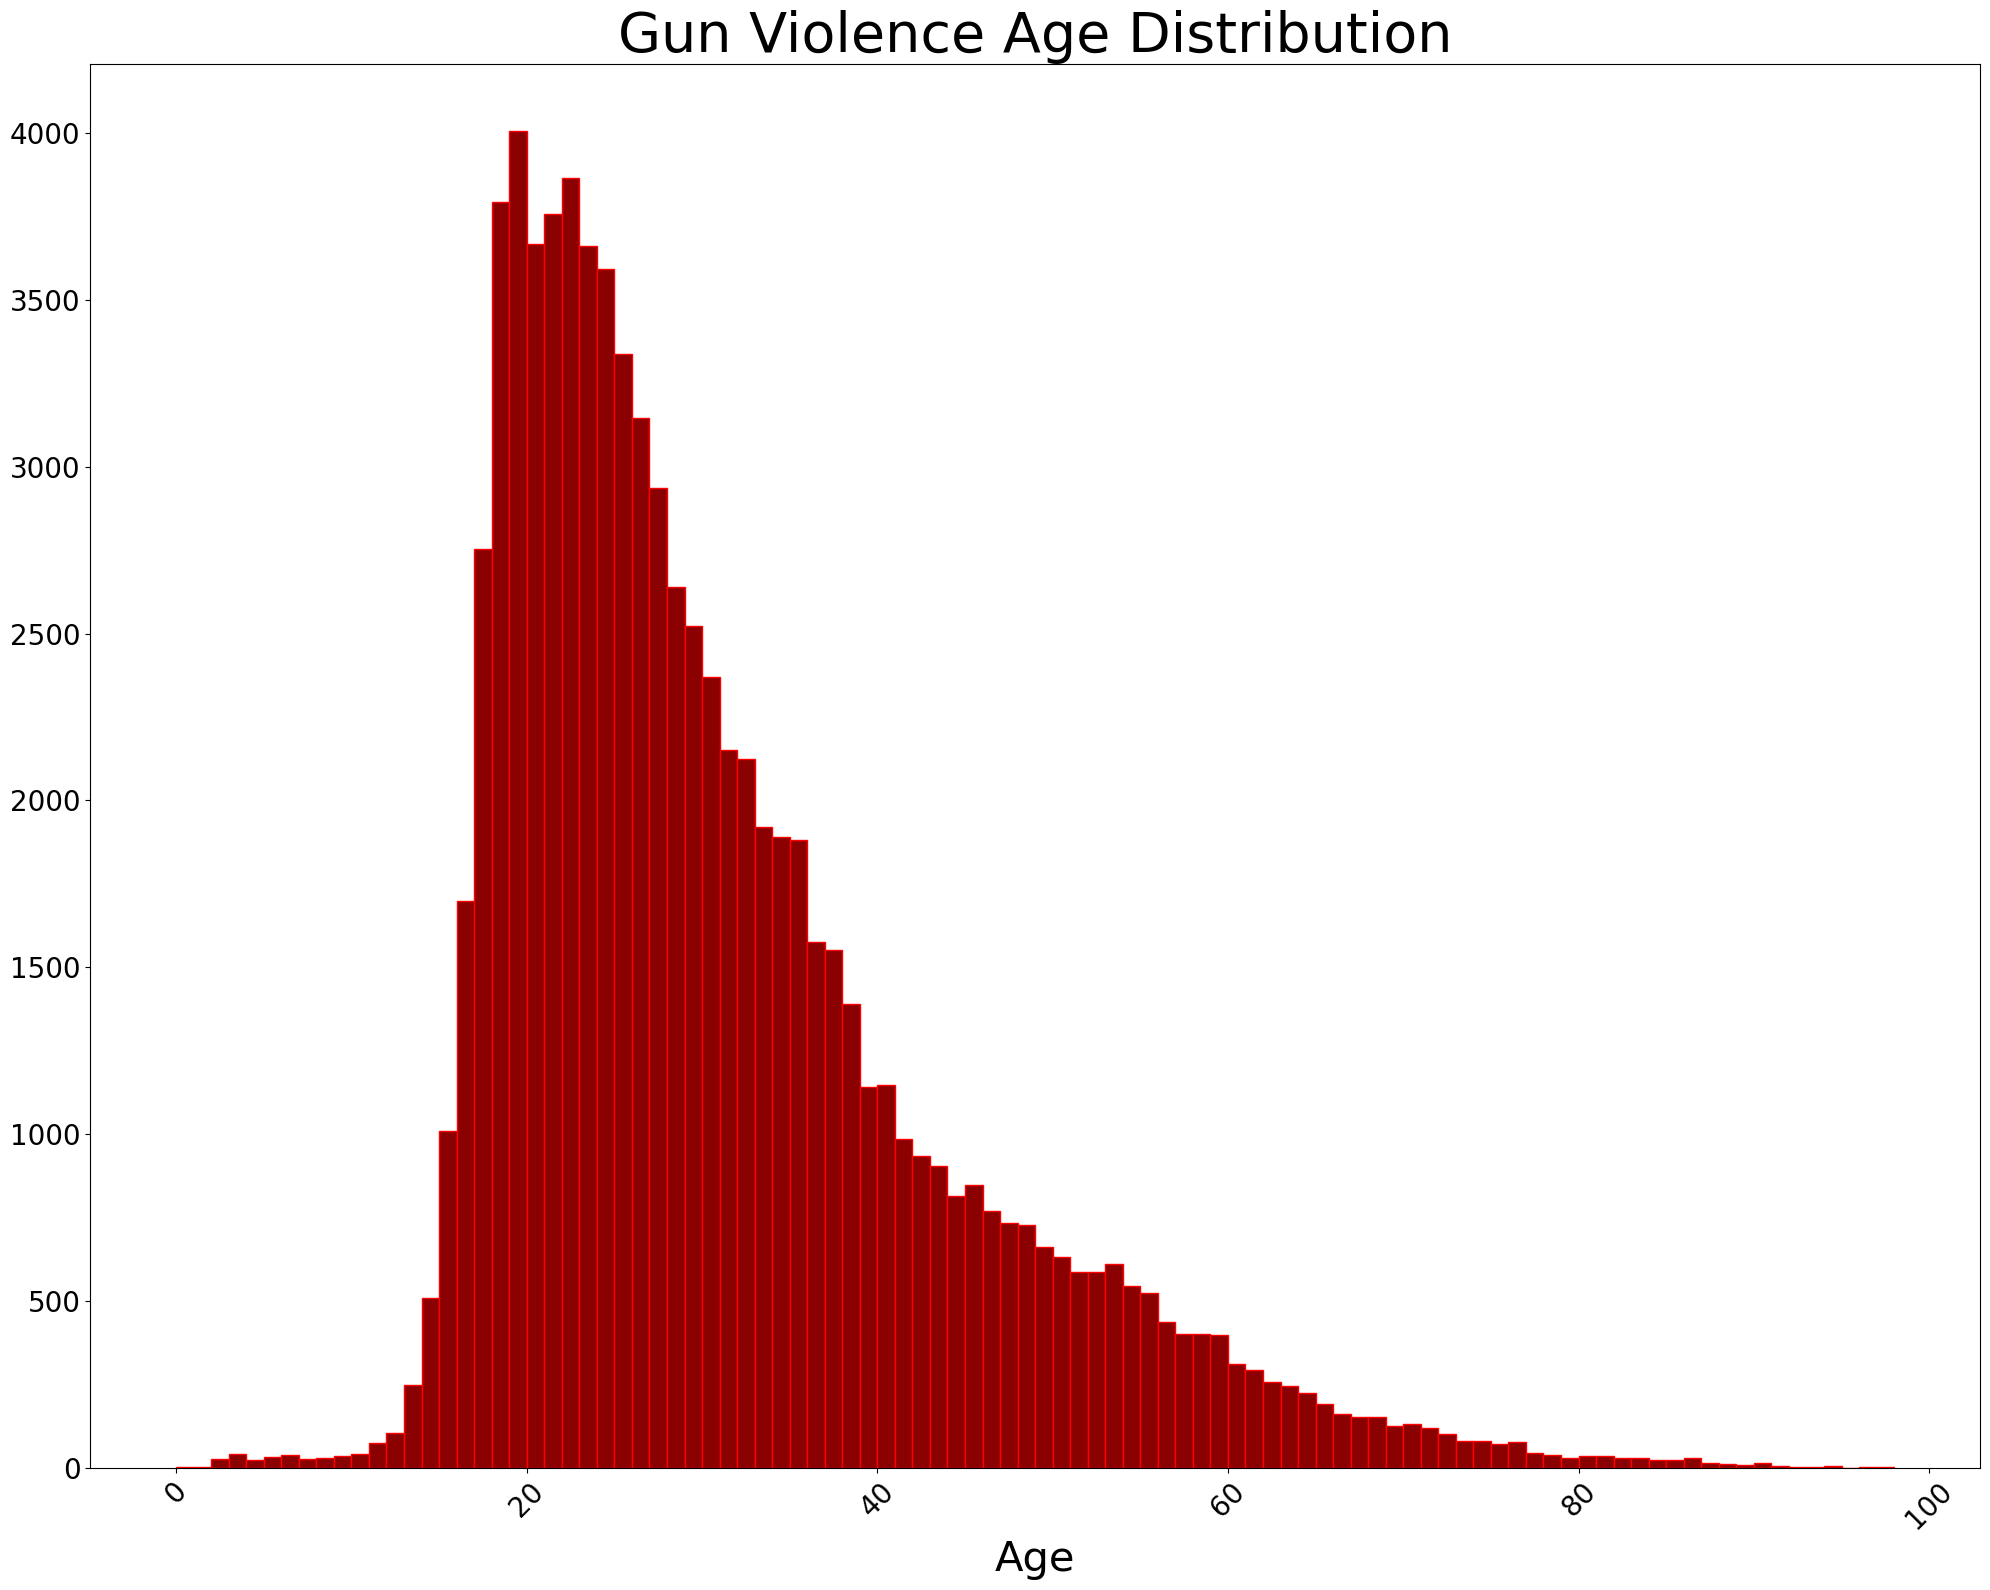

In [278]:
plt.figure(figsize=(20, 16))
plt.hist(gun[~gun.suspect_age.isna()].suspect_age.sort_values(), bins=98, color='darkred', edgecolor='black')

plt.title('Gun Violence Age Distribution', size=40)
plt.xlabel('Age', size=30)

plt.xticks(rotation=45, size=20)
plt.yticks(size=20)

plt.tight_layout()
plt.savefig('../images/gun_violence_age_distribution.png', dpi=192);

In [61]:
gun.suspect_age.describe()

count    82383.000000
mean        30.617518
std         12.883701
min          0.000000
25%         21.000000
50%         27.000000
75%         37.000000
max         98.000000
Name: suspect_age, dtype: float64

In [170]:
teen = gun[(gun.suspect_age < 18) & (gun.suspect_age > 12)].suspect_age.value_counts().sort_values(ascending=False)
teen.head()

suspect_age
17.0    2752
16.0    1697
15.0    1009
14.0     509
13.0     248
Name: count, dtype: int64

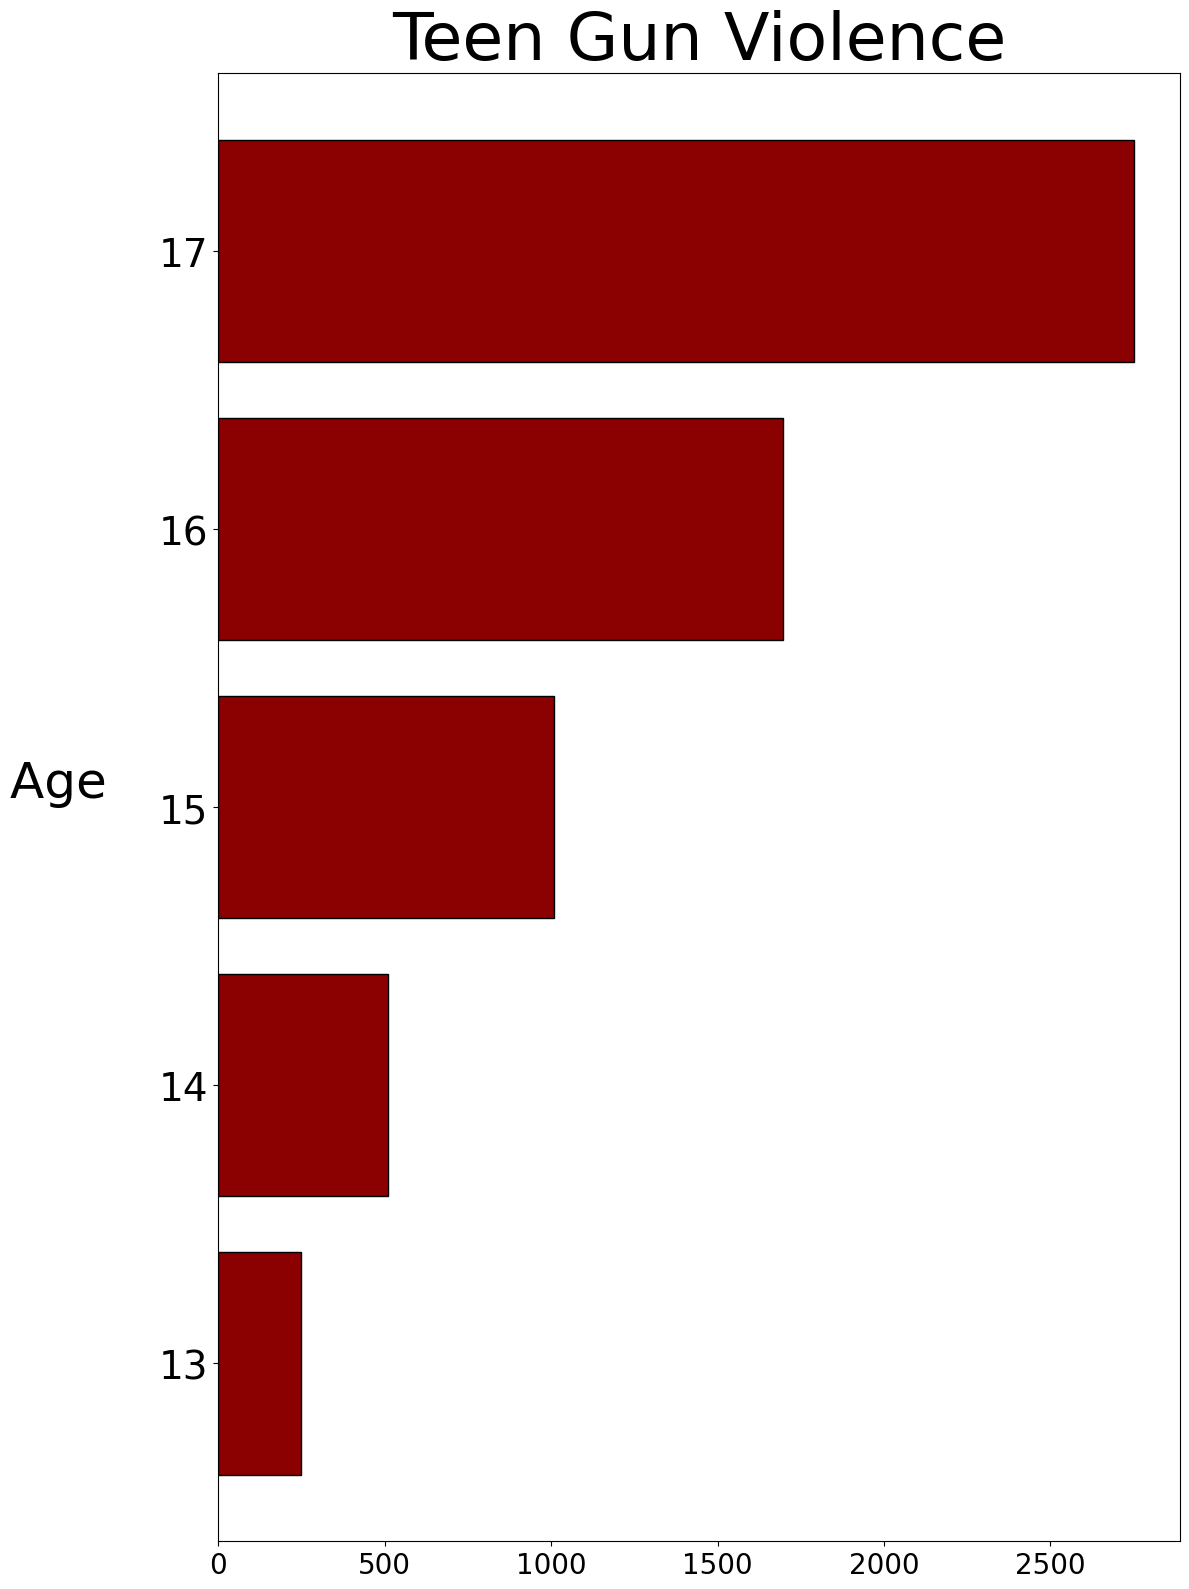

In [276]:
plt.figure(figsize=(12, 16))
plt.barh(teen.index, teen, color='darkred', edgecolor='black')

plt.title('Teen Gun Violence', size=48)
plt.ylabel('Age            ', size=36, rotation=0)

plt.yticks(size=28)
plt.xticks(size=20)

plt.tight_layout()
plt.savefig('../images/gun_violence_age_teen.png', dpi=192);

In [63]:
teen_gun_violence = gun[(gun.suspect_age < 18) & (gun.suspect_age > 12)].suspect_age.value_counts().sort_values(ascending=False).sum()

In [64]:
# percentage of gun violence that is teens (of rows where age is not NAN)
teen_gun_violence / gun[~gun.suspect_age.isna()].shape[0]

0.07544032142553682

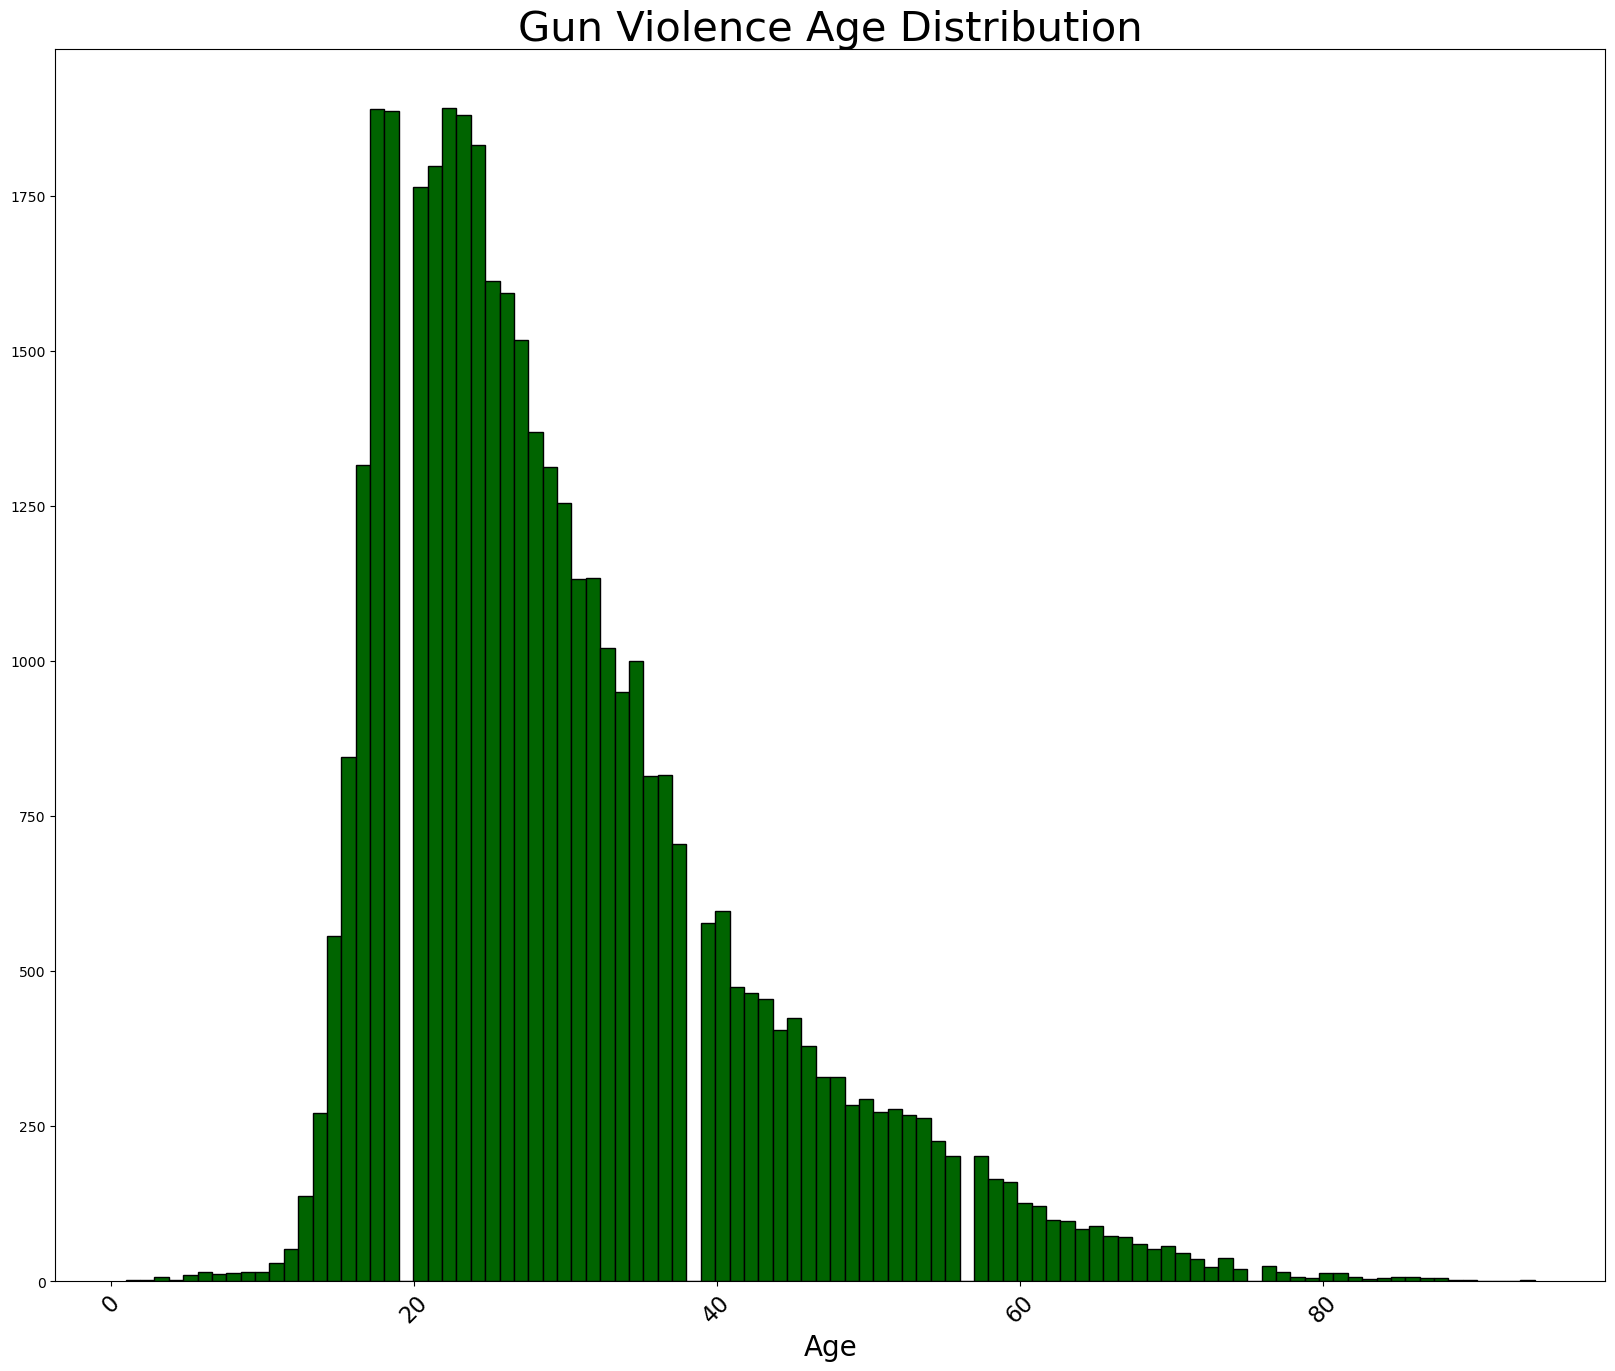

In [65]:
plt.figure(figsize=(20, 16))
plt.hist(gun[(~gun.suspect_age.isna()) & (gun.casualties == 0)].suspect_age.sort_values(), bins=98, color='darkgreen', edgecolor='black')

plt.title('Gun Violence Age Distribution', size=30)
plt.xlabel('Age', size=20)

plt.xticks(rotation=45, size=16);

In [253]:
gender = gun[['suspect_gender']].value_counts().sort_values(ascending=False)

In [257]:
gender_total = gender.sum()
gender_perc = gender / gender_total
gender_perc

suspect_gender
Male              0.93394
Female            0.06606
Name: count, dtype: float64

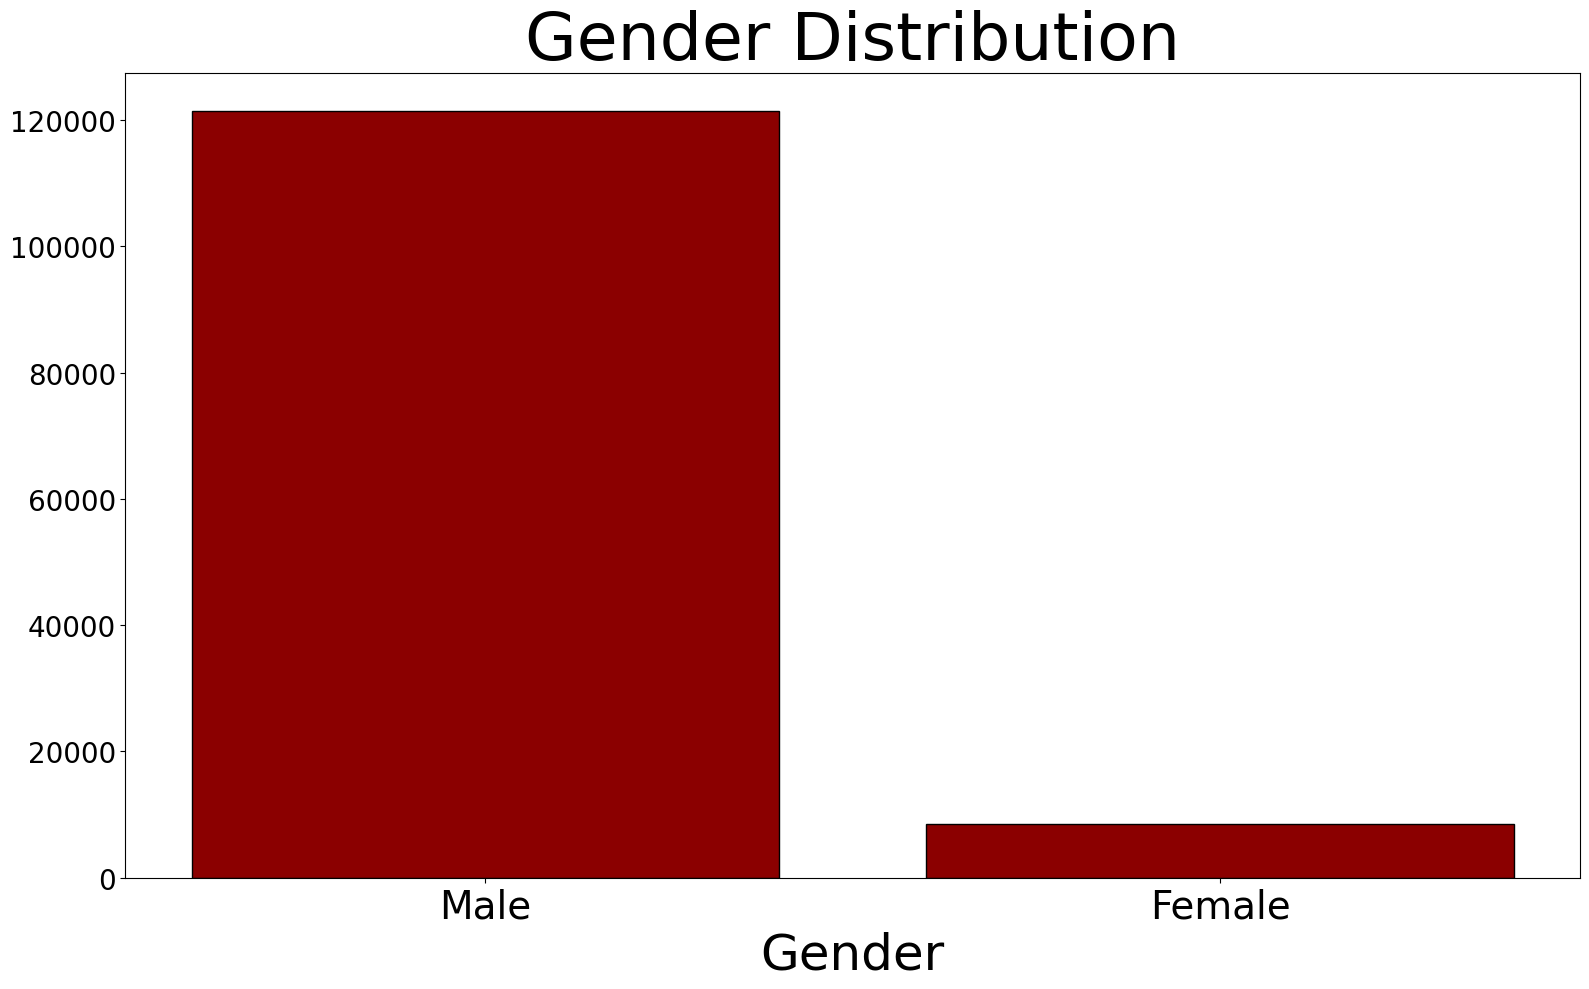

In [237]:
plt.figure(figsize=(16, 10))
plt.bar(gender.index, gender.suspect_gender, color='darkred', edgecolor='black')

plt.title('Gender Distribution', size=48)
plt.xlabel('Gender', size=36, rotation=0)

plt.yticks(size=20)
plt.xticks(size=28)

plt.tight_layout()
plt.savefig('../images/gun_violence_gender.png', dpi=192);

In [67]:
gun.suspect_status.value_counts().sort_values(ascending=False).head(20)

suspect_status
Unharmed, Arrested             60130
Unharmed                       54065
Killed                          8073
Arrested                        7196
Injured                         3979
Injured, Arrested               2123
Killed, Arrested                  30
Injured, Unharmed, Arrested       16
Killed, Unharmed                  13
Killed, Unharmed, Arrested         8
Injured, Unharmed                  7
Killed, Injured                    1
Name: count, dtype: int64

In [68]:
gun.n_guns_involved
gun_city_state = gun[['n_injured', 
     'n_killed', 
     'n_guns_involved',
     'casualties',
     'suspect_age', 
     'city_or_county', 
     'state']].groupby(by=['city_or_county', 'state']).mean().reset_index()

gun_city_state.sort_values('casualties', ascending=False).head(20)

,city_or_county,state,n_injured,n_killed,n_guns_involved,casualties,suspect_age
15383,Sutherland Springs,Texas,20.0,27.0,4.0,47.0,26.0
6973,Hesston,Kansas,14.0,4.0,2.0,18.0,38.0
12732,Pompano Beach (Parkland),Florida,9.5,8.5,2.0,18.0,19.0
6070,Goleta (Isla Vista),California,8.0,4.0,NaN,12.0,22.0
15951,Tyrone,Missouri,1.0,8.0,1.0,9.0,36.0
9497,Manchester,Illinois,1.0,6.0,2.0,7.0,NaN
8618,Lawrenceville,Virginia,7.0,0.0,1.0,7.0,NaN
16518,Washington Navy Yard,District of Columbia,1.5,5.5,2.0,7.0,34.0
5859,Geddes,South Dakota,0.0,6.0,1.0,6.0,41.0
244,Alturas,California,2.0,4.0,1.0,6.0,44.0


In [69]:
gun[['n_injured', 
     'n_killed', 
     'n_guns_involved', 
     'suspect_age', 
     'suspect_gender', 
     'city_or_county', 
     'state']].dtypes

n_injured            int64
n_killed             int64
n_guns_involved    float64
suspect_age        float64
suspect_gender      object
city_or_county      object
state               object
dtype: object

In [227]:
dow = gun[['n_killed', 'day_of_week']].groupby(by='day_of_week').sum().reset_index()

In [229]:
dow['day_of_week_str'] = dow.day_of_week.apply(lambda x: calendar.day_abbr[x])
dow.head()

,day_of_week,n_killed,day_of_week_str
0,0,8383,Mon
1,1,7917,Tue
2,2,8083,Wed
3,3,7732,Thu
4,4,8353,Fri


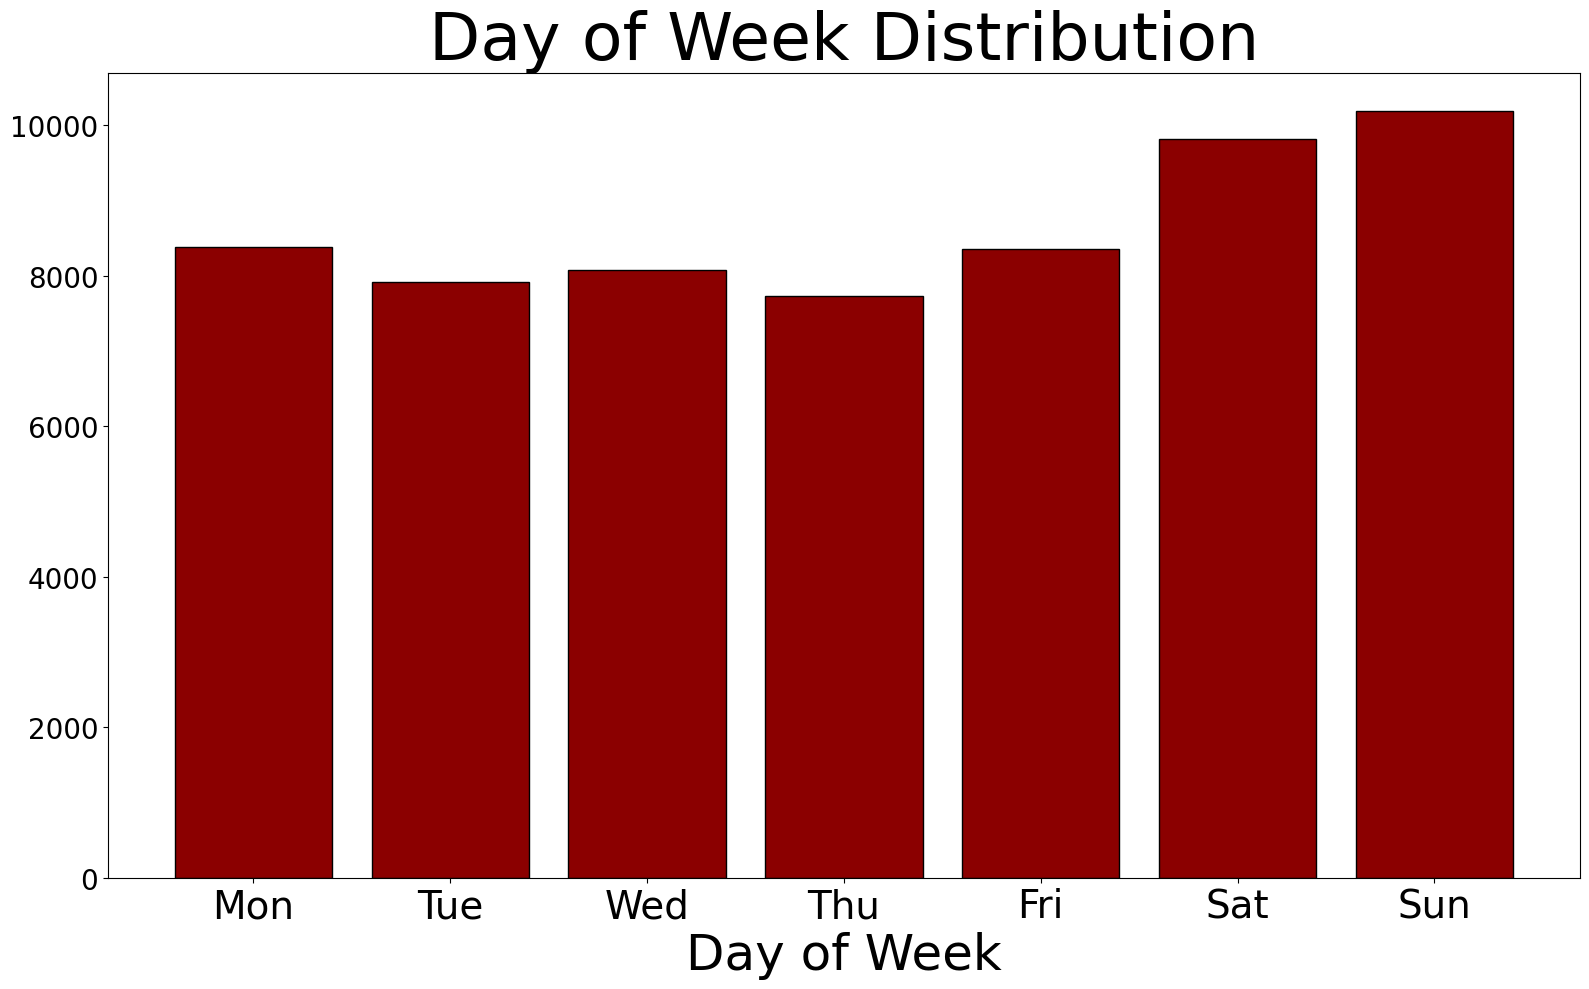

In [231]:
plt.figure(figsize=(16, 10))
plt.bar(dow.day_of_week_str, dow.n_killed, color='darkred', edgecolor='black')

plt.title('Day of Week Distribution', size=48)
plt.xlabel('Day of Week', size=36, rotation=0)

plt.yticks(size=20)
plt.xticks(size=28)

plt.tight_layout()
plt.savefig('../images/gun_violence_weekly.png', dpi=192);

In [267]:
month = gun[['n_killed', 'month']].groupby(by='month').sum().reset_index()
month['month_str'] = month.month.apply(lambda x: calendar.month_abbr[x])
month.head()

,month,n_killed,month_str
0,1,6035,Jan
1,2,4945,Feb
2,3,5641,Mar
3,4,4383,Apr
4,5,4830,May


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'Jun'),
  Text(6, 0, 'Jul'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sep'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

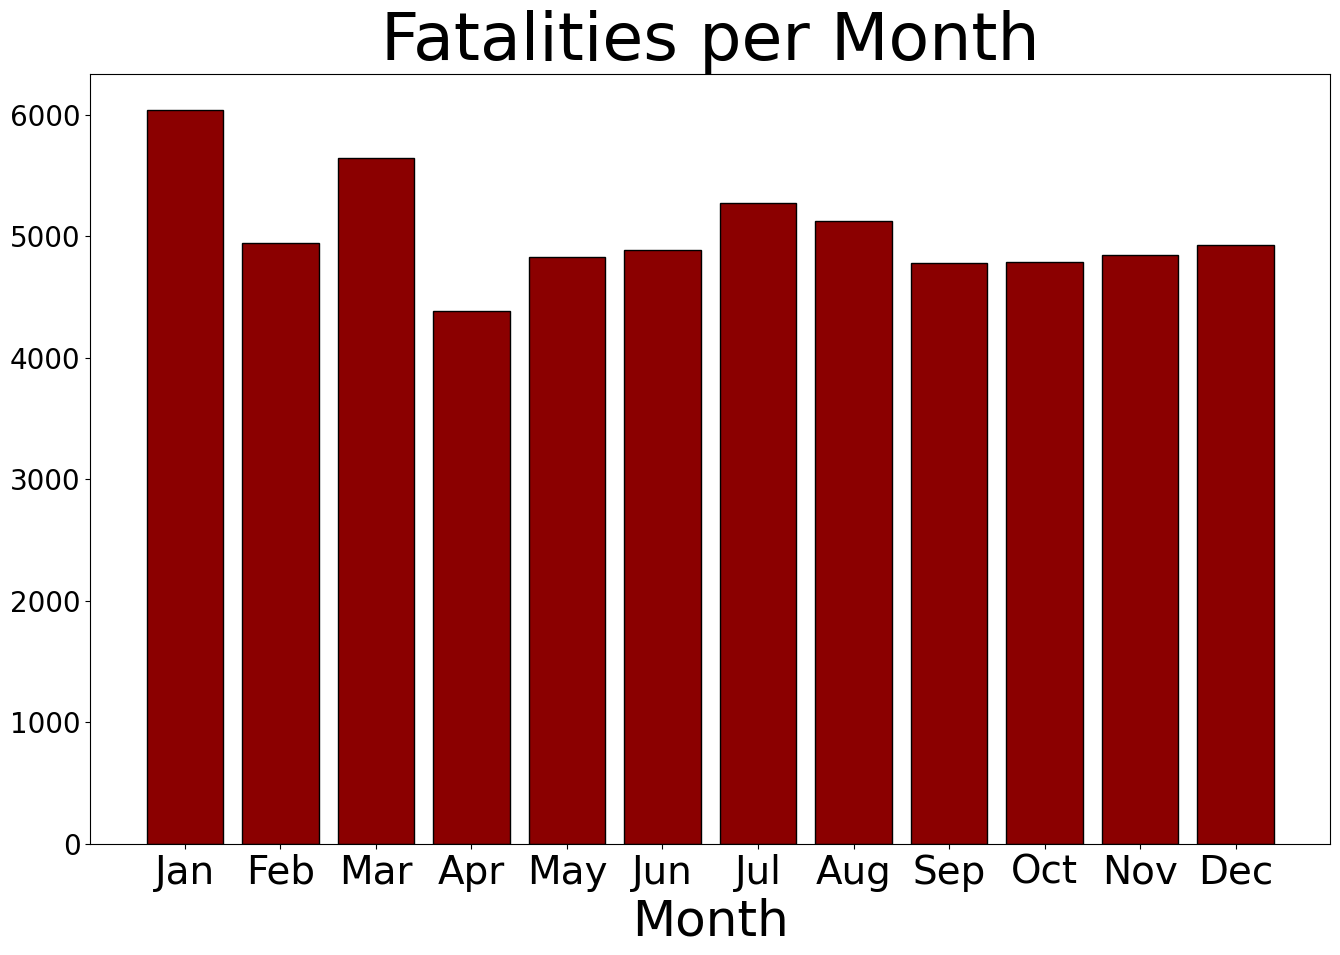

In [269]:
plt.figure(figsize=(16, 10))
plt.bar(month.month_str, month.n_killed, color='darkred', edgecolor='black')

plt.title('Fatalities per Month', size=48)
plt.xlabel('Month', size=36, rotation=0)

plt.yticks(size=20)
plt.xticks(size=28);

# plt.tight_layout()
# plt.savefig('../images/gun_violence_weekly.png', dpi=192);

In [70]:
# This is just for reading through the incident notes, which is kind of interesting
start = 500
rows = 100

count = 0
for i, parts in gun[(~gun.notes.isna()) & (gun.state == 'Washington')].iterrows():
    if count >= start:
        if count % 10 == 0 and count != start:
            print()
        print(f'{i}\t{parts[18]}')
    if count >= start + rows:
        break
    count += 1

65681	Victim reported as Lonell/Larnell.
65865	Originally reported as road rage: ruled out. Connected to 12-15 other gang shootings. 4 POI taken into custody.
65913	Armed robbers stole 6 handguns and a rifle, $10,000's cash, four watches, and the victim's surveillance system. They took a puppy, but let it go.
65966	Burglars ran from traffic stop; led police in car chase and on foot. Grabbed officer's taser and shocked him with it. Gun, meth, heroin found in car
65976	Husband was served protection order from the wife only hours before the shooting.
66361	Two women in car watching two men fighting by street. One man shot at the other, bullet missed and struck woman in car. Her car and another bloody car impounded
66366	Victim shot with .22-caliber pellet rifle. Perp led police in standoff for 30 minutes before surrendering.;
45.707695, -122.602955
66378	outside Hells Angels Clubhouse. 9mm cartidge cases found in street. 3 more guns sitting in plain view inside clubhouse. victim and witne

C:\Users\Cameron\AppData\Local\Temp\ipykernel_22692\3154919959.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{i}\t{parts[18]}')


Amusing notes:

8568	shot by owner of Northwest Healing Arts (marijuana dispensary)

17189	le warrant

22584	cj - attempted, couldn't drive stick

23773	over a burrito

Man shoots self in foot, then hands gun to another man who flees the scene; no charges pressed against the man thus far

54677	Man attempting to invade home accidentally shoots self, flees; Kitsap County, Parkwood East community

In [71]:
# pd.set_option('display.max_colwidth', None)

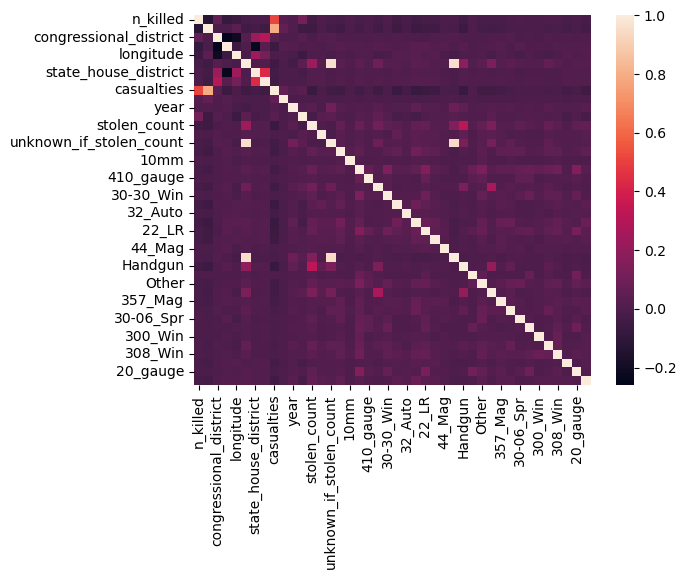

In [72]:
fields_to_remove = ['date', 
                    'incident_id', 
                    'incident_url_fields_missing']
heatmap_cols_w_obj = [x for x in gun.columns if x not in incident_flags_cleaned + fields_to_remove]
heatmap_cols = []
for col in heatmap_cols_w_obj:
    if not pd.api.types.is_object_dtype(gun[col]):
        heatmap_cols.append(col)

sns.heatmap(gun[heatmap_cols].corr());

## Feature Engineering

In [75]:
gun.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing',
       ...
       'LOCKDOWN_ALERT_ONLY_No_GV_Incident_Occurred_Onsite', 'Road_rage',
       'Kidnapping_abductions_hostage', 'Domestic_Violence',
       'Officer_Involved_Shooting_Officer_shot', 'NAV', 'Child_injured_self',
       'Workplace_shooting_disgruntled_employee',
       'Accidental_Shooting_at_a_Business', 'Home_Invasion_Resident_injured'],
      dtype='object', length=178)

In [76]:
gun.isna().mean()

incident_id                                0.00000
date                                       0.00000
state                                      0.00000
city_or_county                             0.00000
address                                    0.06883
                                            ...   
NAV                                        0.00000
Child_injured_self                         0.00000
Workplace_shooting_disgruntled_employee    0.00000
Accidental_Shooting_at_a_Business          0.00000
Home_Invasion_Resident_injured             0.00000
Length: 178, dtype: float64

In [77]:
gun.dtypes

incident_id                                         int64
date                                       datetime64[ns]
state                                              object
city_or_county                                     object
address                                            object
                                                ...      
NAV                                                 int64
Child_injured_self                                  int64
Workplace_shooting_disgruntled_employee             int64
Accidental_Shooting_at_a_Business                   int64
Home_Invasion_Resident_injured                      int64
Length: 178, dtype: object

In [78]:
gun.loc[gun.address.isna(), 'address'] = 'none'

In [79]:
gun.loc[gun.notes.isna(), 'notes'] = 'missingnotes'

In [80]:
gun.loc[gun.location_description.isna(), 'location_description'] = 'missinglocationdescription'

In [81]:
gun['has_casualties'] = 0
gun.loc[gun.casualties > 0, 'has_casualties'] = 1
gun.has_casualties.value_counts()

has_casualties
1    142390
0     97287
Name: count, dtype: int64

In [82]:
y_vars = [
 'n_killed',
 'n_injured', 
 'casualties'
]

y_class = [
    'has_casualties'
]

features = [
 'day_of_week', 
 'state',
 # 'city_or_county',
 # 'address',
 'latitude',
 'longitude', 
 'notes',
 'location_description',
 'n_guns_involved', 
 'suspect_age',  
 'suspect_gender', 
 'stolen_count', 
 #'not_stolen_count',
 'Other',
 '10mm', 
 '40_SW', 
 'Handgun', 
 '357_Mag', 
 '16_gauge', 
 '25_Auto',
 '7.62_AK-47', 
 '44_Mag', 
 '308_Win', 
 '223_Rem_AR-15', 
 '38_Spl',
 '30-06_Spr', 
 '45_Auto', 
 '410_gauge', 
 '30-30_Win', 
 '22_LR', 
 'Shotgun',
 '9mm', 
 '12_gauge', 
 'Rifle', 
 '380_Auto', 
 '32_Auto', 
 '28_gauge',
 '300_Win', 
 '20_gauge',
 'n_killed',
 'n_injured', 
 'casualties',
 'has_casualties'
]

In [83]:
features_raw = gun[features + valid_incident_flags].copy(deep=True)

In [84]:
# drop 3% of rows where lat/long is null
features_raw = features_raw[features_raw.latitude.notna()]

In [85]:
features_raw.suspect_age.mean()

30.638136456211814

impute missing data (or just drop it)

In [86]:
# Impute age, make it mean age when missing
features_raw.loc[features_raw.suspect_age.isna(), 'suspect_age'] = features_raw.suspect_age.mean()

In [87]:
# Impute guns involved. There's at least one gun involved.
features_raw.loc[features_raw.n_guns_involved.isna(), 'n_guns_involved'] = 1

In [88]:
# features_raw.suspect_gender.value_counts()

In [89]:
# Fill in missing gender
features_raw.loc[features_raw.suspect_gender.isna(), 'suspect_gender'] = 'unknown'

In [90]:
%%time
# features_raw.isna().mean()

CPU times: total: 0 ns
Wall time: 0 ns


dummify/one-hot

In [91]:
X = pd.get_dummies(features_raw.drop(columns=(y_vars + y_class)), columns=['state', 'suspect_gender'], drop_first=True)
X.columns

Index(['day_of_week', 'latitude', 'longitude', 'notes', 'location_description',
       'n_guns_involved', 'suspect_age', 'stolen_count', 'Other', '10mm',
       ...
       'state_Texas', 'state_Utah', 'state_Vermont', 'state_Virginia',
       'state_Washington', 'state_West Virginia', 'state_Wisconsin',
       'state_Wyoming', 'suspect_gender_Male', 'suspect_gender_unknown'],
      dtype='object', length=158)

In [92]:
fixed_cols = [col.replace(' ', '_') for col in X.columns]
X.columns = fixed_cols

In [93]:
# X.head()

In [94]:
# for col in X.columns:
#     print(X[col].dtype)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, features_raw[y_vars[2]], random_state=666420)

In [96]:
X_train.shape, y_train.shape

((173815, 158), (173815,))

In [125]:
# Baseline model accuracy
features_raw['has_casualties'].mean()

0.5898495818842393

### Linear Regression Model

In [98]:
# initialise model and vectorizers
model = LinearRegression()
tvectorizer1 = TfidfVectorizer()
tvectorizer2 = TfidfVectorizer()
# sc = StandardScaler()

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('notes_tfidf', tvectorizer1, 'notes'),
    ('loc_tfidf', tvectorizer2, 'location_description')],
    remainder='passthrough')


pipe = Pipeline([
                  ('transformed', column_transformer),
                  ('classify', model)
                ])

In [99]:
pipe.get_params()

{'memory': None,
 'steps': [('transformed',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('notes_tfidf', TfidfVectorizer(), 'notes'),
                                   ('loc_tfidf', TfidfVectorizer(),
                                    'location_description')])),
  ('classify', LinearRegression())],
 'verbose': False,
 'transformed': ColumnTransformer(remainder='passthrough',
                   transformers=[('notes_tfidf', TfidfVectorizer(), 'notes'),
                                 ('loc_tfidf', TfidfVectorizer(),
                                  'location_description')]),
 'classify': LinearRegression(),
 'transformed__n_jobs': None,
 'transformed__remainder': 'passthrough',
 'transformed__sparse_threshold': 0.3,
 'transformed__transformer_weights': None,
 'transformed__transformers': [('notes_tfidf', TfidfVectorizer(), 'notes'),
  ('loc_tfidf', TfidfVectorizer(), 'location_description')],
 'transformed__verbose': False,
 'transformed__verbose

In [100]:
%%time
ngram_range =  [(1,1)]
# ngram_range = [(1,1), (1,2), (2,2)]
stop_words = ['english', None]
# stop_words = [None]
min_df = [1, 2]
# min_df = [2]

pgrid = [
    {
        'transformed__notes_tfidf__ngram_range': ngram_range,
        'transformed__notes_tfidf__stop_words': stop_words,
        'transformed__notes_tfidf__min_df': min_df,
        'transformed__loc_tfidf__ngram_range': ngram_range,
        'transformed__loc_tfidf__stop_words': stop_words,
        'transformed__loc_tfidf__min_df': min_df
    }
]
    
gs_linr = GridSearchCV(estimator=pipe, param_grid=pgrid, cv=5, n_jobs=10)
gs_linr.fit(X_train, y_train)

CPU times: total: 1min 22s
Wall time: 5min 45s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformed',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('notes_tfidf',
                                                                         TfidfVectorizer(),
                                                                         'notes'),
                                                                        ('loc_tfidf',
                                                                         TfidfVectorizer(),
                                                                         'location_description')])),
                                       ('classify', LinearRegression())]),
             n_jobs=10,
             param_grid=[{'transformed__loc_tfidf__min_df': [1, 2],
                          'transformed__loc_tfidf__ngram_range': [(1, 1)],
                          'transformed__loc_tfidf__stop_words': ['english',
                                                                 None],
                          'transformed__notes_tfidf__min_df': [1, 2],
                          'transformed__notes_tfidf__ngram_range': [(1, 1)],
                          'transformed__notes_tfidf__stop_words': ['english',
                                                                   None]}])

In [101]:
%%time
gs_linr.score(X_train, y_train), gs_linr.score(X_test, y_test)

CPU times: total: 2.52 s
Wall time: 2.12 s


(0.5380575631431987, 0.2935890670799063)

In [102]:
gs_linr.best_params_

{'transformed__loc_tfidf__min_df': 2,
 'transformed__loc_tfidf__ngram_range': (1, 1),
 'transformed__loc_tfidf__stop_words': 'english',
 'transformed__notes_tfidf__min_df': 2,
 'transformed__notes_tfidf__ngram_range': (1, 1),
 'transformed__notes_tfidf__stop_words': None}

In [103]:
linr_best = gs_linr.best_estimator_

We're predicting an integer, not the whole set of real numbers, so the actual prediction should be rounded

In [149]:
linr_preds = linr_best.predict(X_test)

In [150]:
linr_results = pd.DataFrame({
    'pred': linr_preds,
    'actual': y_test})
linr_results['rounded'] = np.round(linr_results.pred).astype(int)
linr_results['rounded_pred_is_correct'] = linr_results.actual == linr_results.rounded
# linr_results.loc[]
linr_results.head()

,pred,actual,rounded,rounded_pred_is_correct
161394,1.274780,1,1,True
99696,0.952459,1,1,True
101390,0.692832,0,1,False
147620,-0.076526,0,0,True
70833,0.903135,1,1,True


In [151]:
linr_results.rounded_pred_is_correct.mean()

0.7727782667978391

Huh. 77% accuracy. Pretty good, all things considered. I did not have high hopes for the linear regression.

In [104]:
linr_best.named_steps['classify'].coef_

array([ 0.23303517, -0.18257159,  0.64552128, ..., -0.46966705,
        0.03478877,  0.11436314])

In [105]:
linr_coefs = pd.DataFrame({
    'col': linr_best.named_steps['transformed'].get_feature_names_out(),
    'coef': linr_best.named_steps['classify'].coef_})
linr_coefs.head()

,col,coef
0,notes_tfidf__00,0.233035
1,notes_tfidf__000,-0.182572
2,notes_tfidf__001,0.645521
3,notes_tfidf__003,0.141917
4,notes_tfidf__005224,-0.346489


### Logistic Regression Model

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, features_raw[y_class[0]], random_state=666420)

model = LogisticRegression()
pipe = Pipeline([
                  ('transformed', column_transformer),
                  ('classify', model)
                ])

In [112]:
pipe.get_params()

{'memory': None,
 'steps': [('transformed',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('notes_tfidf', TfidfVectorizer(), 'notes'),
                                   ('loc_tfidf', TfidfVectorizer(),
                                    'location_description')])),
  ('classify', LogisticRegression())],
 'verbose': False,
 'transformed': ColumnTransformer(remainder='passthrough',
                   transformers=[('notes_tfidf', TfidfVectorizer(), 'notes'),
                                 ('loc_tfidf', TfidfVectorizer(),
                                  'location_description')]),
 'classify': LogisticRegression(),
 'transformed__n_jobs': None,
 'transformed__remainder': 'passthrough',
 'transformed__sparse_threshold': 0.3,
 'transformed__transformer_weights': None,
 'transformed__transformers': [('notes_tfidf', TfidfVectorizer(), 'notes'),
  ('loc_tfidf', TfidfVectorizer(), 'location_description')],
 'transformed__verbose': False,
 'transformed__ver

In [113]:
%%time
ngram_range =  [(1,1)]
# ngram_range = [(1,1), (1,2), (2,2)]
stop_words = ['english', None]
# stop_words = [None]
min_df = [1, 2]
# min_df = [2]

pgrid = [
    {
        'transformed__notes_tfidf__ngram_range': ngram_range,
        'transformed__notes_tfidf__stop_words': stop_words,
        'transformed__notes_tfidf__min_df': min_df,
        'transformed__loc_tfidf__ngram_range': ngram_range,
        'transformed__loc_tfidf__stop_words': stop_words,
        'transformed__loc_tfidf__min_df': min_df,

        'classify__penalty': [None],
        'classify__max_iter': [2000]
    }
]
    
gs_logr = GridSearchCV(estimator=pipe, param_grid=pgrid, cv=5, n_jobs=10)
gs_logr.fit(X_train, y_train)

CPU times: total: 3min 33s
Wall time: 9min 11s


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformed',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('notes_tfidf',
                                                                         TfidfVectorizer(),
                                                                         'notes'),
                                                                        ('loc_tfidf',
                                                                         TfidfVectorizer(),
                                                                         'location_description')])),
                                       ('classify', LogisticRegression())]),
             n_jobs=10,
             param_grid=[{'classify__max_iter': [2000],
                          'classify__penalty': [None],
                          'transformed__loc_tfidf__min_df': [1, 2],
                          'transformed__loc_tfidf__ngram_range': [(1, 1)],
                          'transformed__loc_tfidf__stop_words': ['english',
                                                                 None],
                          'transformed__notes_tfidf__min_df': [1, 2],
                          'transformed__notes_tfidf__ngram_range': [(1, 1)],
                          'transformed__notes_tfidf__stop_words': ['english',
                                                                   None]}])

In [114]:
%%time
gs_logr.score(X_train, y_train), gs_logr.score(X_test, y_test)

CPU times: total: 2.56 s
Wall time: 2.07 s


(0.8987083968587292, 0.8959077650632562)

In [115]:
gs_logr.best_params_

{'classify__max_iter': 2000,
 'classify__penalty': None,
 'transformed__loc_tfidf__min_df': 1,
 'transformed__loc_tfidf__ngram_range': (1, 1),
 'transformed__loc_tfidf__stop_words': 'english',
 'transformed__notes_tfidf__min_df': 2,
 'transformed__notes_tfidf__ngram_range': (1, 1),
 'transformed__notes_tfidf__stop_words': None}

In [116]:
logr_best = gs_logr.best_estimator_

In [117]:
linr_best.named_steps['classify'].coef_.shape

(17359,)

In [118]:
linr_best.named_steps['classify'].coef_

array([ 0.23303517, -0.18257159,  0.64552128, ..., -0.46966705,
        0.03478877,  0.11436314])

In [119]:
linr_best.named_steps['transformed'].get_feature_names_out().shape

(17359,)

In [120]:
# weird shape here
logr_best.named_steps['classify'].coef_.shape

(1, 23665)

In [121]:
# that's better
logr_best.named_steps['classify'].coef_[0].shape

(23665,)

In [122]:
logr_best.named_steps['transformed'].get_feature_names_out().shape

(23665,)

In [123]:
logr_coefs = pd.DataFrame({
    'col': logr_best.named_steps['transformed'].get_feature_names_out(),
    'coef': logr_best.named_steps['classify'].coef_[0]})
logr_coefs.head()

,col,coef
0,notes_tfidf__00,0.858030
1,notes_tfidf__000,-0.358018
2,notes_tfidf__001,0.028406
3,notes_tfidf__003,-0.002063
4,notes_tfidf__005224,-0.078723


### Model EDA

In [126]:
pd.set_option('display.max_colwidth', None)
linr_coefs.head()

,col,coef
0,notes_tfidf__00,0.233035
1,notes_tfidf__000,-0.182572
2,notes_tfidf__001,0.645521
3,notes_tfidf__003,0.141917
4,notes_tfidf__005224,-0.346489


In [159]:
linr_coefs.sort_values('coef').head(40)

,col,coef
13223,loc_tfidf__carter,-14.970286
5177,notes_tfidf__gaskin,-13.728882
8117,notes_tfidf__ocala,-12.430788
1002,notes_tfidf__930,-10.705417
7858,notes_tfidf__naples,-8.530739
823,notes_tfidf__62x39,-7.206578
173,notes_tfidf__139,-6.238803
6063,notes_tfidf__immigration,-5.870425
10476,notes_tfidf__southridge,-5.585996
13002,loc_tfidf__brandon,-5.392871


In [160]:
linr_coefs.sort_values('coef', ascending=False).head(60)

,col,coef
4581,notes_tfidf__every,79.130686
11801,notes_tfidf__verify,66.092909
3708,notes_tfidf__darius,31.553820
6210,notes_tfidf__intend,29.002033
1655,notes_tfidf__attendees,23.944181
15923,loc_tfidf__pulse,20.539478
7257,notes_tfidf__manuel,15.108987
5756,notes_tfidf__hesston,14.918534
12367,notes_tfidf__yds,12.697569
4362,notes_tfidf__effort,12.411073


In [164]:
linr_coefs[linr_coefs.col.str.find('remainder__') > -1].sort_values('coef').head(40)

,col,coef
17292,remainder__TSA_Action,-0.667581
17243,remainder__NAV,-0.545372
17266,remainder__Shots_fired_no_action_reported_no_evidence_found,-0.520973
17236,remainder__NonShooting_Incident,-0.489008
17297,remainder__Child_picked_up_&_fired_gun,-0.488390
17356,remainder__state_Wyoming,-0.469667
17269,remainder__Child_with_gun_no_shots_fired,-0.453512
17296,remainder__Gun_buy_back_action,-0.404429
17245,remainder__ShotSpotter,-0.330571
17252,remainder__Guns_stolen_from_owner,-0.303981


In [163]:
linr_coefs[linr_coefs.col.str.find('remainder__') > -1].sort_values('coef', ascending=False).head(40)

,col,coef
17268,remainder__Terrorism_Involvement,1.793886
17239,remainder__Hate_crime,1.029236
17301,remainder__Attempted_Murder_Suicide_one_variable_unsuccessful,0.773495
17300,remainder__Pistolwhipping,0.526419
17264,remainder__School_Shooting_elementary_secondary_school,0.515210
17272,remainder__Child_Involved_Incident,0.500297
17260,remainder__Bar_club_incident_in_or_around_establishment,0.350616
17242,remainder__Workplace_shooting_disgruntled_employee,0.328068
17281,remainder__House_party,0.305850
17285,remainder__School_Shooting_university_college,0.302107


In [131]:
logr_coefs.sort_values('coef').head(40)

,col,coef
7988,notes_tfidf__no,-15.996274
23598,remainder__TSA_Action,-13.268883
4862,notes_tfidf__fired,-11.332465
6038,notes_tfidf__if,-7.452850
4869,notes_tfidf__fires,-7.298276
4105,notes_tfidf__dog,-6.561444
1231,notes_tfidf__air,-6.185810
3686,notes_tfidf__damage,-5.855439
8122,notes_tfidf__occupied,-5.527478
2765,notes_tfidf__casings,-5.208991


In [156]:
logr_coefs.sort_values('coef', ascending=False).head(60)

,col,coef
6583,notes_tfidf__killed,14.291467
9115,notes_tfidf__pw,10.057277
12299,notes_tfidf__wounded,9.947672
10203,notes_tfidf__shot,9.543935
10604,notes_tfidf__stable,8.810821
6857,notes_tfidf__leg,8.576831
5395,notes_tfidf__grazed,7.486245
6175,notes_tfidf__injured,7.470707
10853,notes_tfidf__suicide,7.310655
10007,notes_tfidf__self,7.219883


In [157]:
logr_coefs[logr_coefs.col.str.find('remainder__') > -1].sort_values('coef').head(40)

,col,coef
23598,remainder__TSA_Action,-13.268883
23602,remainder__Gun_buy_back_action,-4.563514
23572,remainder__Shots_fired_no_action_reported_no_evidence_found,-4.244175
23542,remainder__NonShooting_Incident,-4.159182
23589,remainder__Animal_shot_killed,-3.456692
23605,remainder__Gun_shop_robbery_or_burglary,-2.548563
23600,remainder__Officer_Involved_Incident_Weapon_involved_but_no_shots_fired,-2.312369
23582,remainder__School_Incident,-2.287142
23556,remainder__Implied_Weapon,-2.278105
23662,remainder__state_Wyoming,-2.269193


In [158]:
pd.set_option('display.max_colwidth', None)
logr_coefs[logr_coefs.col.str.find('remainder__') > -1].sort_values('coef', ascending=False).head(40)

,col,coef
23606,remainder__Pistolwhipping,5.369256
23570,remainder__School_Shooting_elementary_secondary_school,3.713597
23607,remainder__Attempted_Murder_Suicide_one_variable_unsuccessful,3.427361
23591,remainder__School_Shooting_university_college,2.852821
23546,remainder__Officer_Involved_Shooting_subject_suspect_perpetrator_suicide_by_cop,2.795487
23555,remainder__Accidental_Shooting,2.641895
23578,remainder__Child_Involved_Incident,1.863361
23611,remainder__Gun_range_gun_shop_gun_show_shooting,1.396908
23554,remainder__Defensive_Use_Stand_Your_Ground_Castle_Doctrine_established,1.306767
23613,remainder__state_Alaska,1.010243


In [272]:
gun[gun.notes.str.lower().str.contains('vape')].notes.head()

25041                                                                                    at N D Vape smoke shop 
174264    Teenager shot in foot during vape machine sale near Southridge Mall.;\r\r\r\r\n41.522782, -93.602397 ;
237173                                                                         shot in vape shop, ALT: Center St
Name: notes, dtype: object